# Food: a relevant marker of social inequalities?

In [28]:
# Imports
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import numpy as np
import folium
import re
import platform
import os
import pyspark
import warnings

from scipy.stats import *
from urllib.request import urlopen
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from pyspark.sql import *
from pyspark.sql.functions import *

# Uncomment to hide Warnings
warnings.filterwarnings('ignore')

In [29]:
# Constants
FIG_SIZE=(10,6)

We've got two datasets: the OpenFoodFact dataset and the INCA study. As we suspected (cf. milestone 1) they are difficult to join. However they are quite complementary: the OpenFoodFact gives us information about products sold in supermarkets and the INCA study gives us information about people's food habits, health and way of life.

## Study of OpenFoodFact

As we are looking at social inequalities we would like to compare 2 categories of products that are not eaten by the same social classes. As OpenFoodFact gives us no information about the price of the products it is quite difficult to dispatch the products in two relevant categories. To solve this problem we've decided to focus on organic and non-organic food because it gives us the possibility to compare similar products (for instance cereals) but it is quite well-known that organic food is more expensive.

We can expect organic food to be healthier because it contains less pesticide but organic food also convey an image of a healthier food in itself (less fat, less sugar,...). Is it true or not? 

### Data cleaning

In [30]:
# Data
OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
OFF_API_QUERY_PATH = "https://world.openfoodfacts.org/cgi/search.pl?{}&page_size=1000&action=process&json=1"

def getOFFDataFrame(adress, path = OFF_API_PATH):
    """
    Queries OFF database with local adress contained in adress. Formatting url is contained in path.
    """
    result = json.load(urlopen(path.format(adress)))
#     print("{} entries gathered".format(result["count"]))
    if "products" in result:
        return pd.DataFrame(result["products"])
    return pd.DataFrame(result["tags"])

def getOFFDataFrameDict(qdict, n = 1000):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    return getOFFDataFrame(q, OFF_API_QUERY_PATH)

def getOFFDataFrameDictAux(qdict, n = 1000, log=False):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    i = 1
    dfs = []
    nbCurr = -1
    nbSamples = 0
    while (nbCurr != 0) & (nbSamples < n):
        dfs.append(getOFFDataFrame(q + "&page=" + str(i), OFF_API_QUERY_PATH))
        nbCurr = dfs[-1].shape[0]
        nbSamples += nbCurr
        i += 1
        if log: 
            print("{} samples gathered.".format(nbSamples))
    return pd.concat(dfs).head(n)

def getOFFDataFrameCat(tags=[], nutriments=[], n = 1000, log=False, **kwargs):
    """
    Queries the OFF data base with query informations contained in tags and nutriments. 
    <ul>
        <li>Tags should be a list of lists of shape: 
        [tag, value, &lt;conatins&gt;] where tag is the category of tag (ex. "brands") and value, the value to 
        be searched (ex. "Carrefour")</li>
        <li>Nutriments should be a list of lists of shape: [nutriment, comparison, value] where nutriment is the name of the nutriment to be 
        searched (ex. "magnesium"), comparison the nature of the comparison (ex. "lte") and 
        value the value to be compared with (ex. 50)</li>
    </ul>
    """
    qdict = {}
    qdict.update(parseTags(tags))
    qdict.update(parseNutriments(nutriments))
    qdict.update(kwargs)
    
    return getOFFDataFrameDictAux(qdict, n, log)

def parseTags(tags):
    """
    Converts tags into an appropriate dictionary like shape
    """
    qdict = {}
    for i, tagsEl in enumerate(tags):
        if len(tagsEl) == 2:
            contains = True
        else:
            contains = tagsEl[2]
        qdict["tagtype_{}".format(i)] = tagsEl[0]
        qdict["tag_contains_{}".format(i)] = ["does_not_contain","contains"][int(contains)]
        qdict["tag_{}".format(i)] = tagsEl[1]
    return qdict

def parseNutriments(nutriments):
    """
    Converts nutriments into an appropriate dictionary like shape
    """
    qdict = {}
    for i, nutrimentsEl in enumerate(nutriments):
        qdict["nutriment_{}".format(i)] = nutrimentsEl[0]
        qdict["nutriment_compare_{}".format(i)] = nutrimentsEl[1]
        qdict["nutriment_value_{}".format(i)] = nutrimentsEl[2]
        nutriment_i += 1
    return qdict

### Data formatting

### Data visualization

In [31]:
def getCategories(df, minlength=4, maxlength=20):
    cats = pd.DataFrame([x.lower() for cats in df["categories"] for x in re.split("\W", str(cats))], columns=["categories"])
    return cats[cats["categories"].apply(lambda x: (len(x) >= minlength) & (len(x) <= maxlength))]

def generateWordCloud(df, stopwordsAdd={},figsize=FIG_SIZE, **kwargs):
    stopwords = set(STOPWORDS)
    stopwords.update(stopwordsAdd)
    kwargsWC = {"background_color":"white", "stopwords":stopwords, "collocations":False, "width":720, "height":480, "margin":0, "colormap":"inferno"}
    kwargsWC.update(kwargs)
    categories = getCategories(df)
    categoriesText = " ".join(categories["categories"])
    
    wc = WordCloud(**kwargsWC).generate(categoriesText)

    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

def generate_mask(path):
    im = np.array(Image.open(path))
    im = im.mean(axis=2, dtype="int16")
    im = 255 * (im > 240)
    return im

def contains(strList, container):
    for s in strList:
        if s in container:
            return True
    return False

def toFloat(x):
    try:
        return float(x)
    except:
        return np.nan

def gatherCategory(df, categories):
    return df[df["categories"].apply(lambda x: contains(categories, str(x)))]

def gatherNutriments(df, nutriment, p=5):
    vals = df["nutriments"].apply(lambda x: toFloat(x.setdefault("{}_100g".format(nutriment), np.nan))).dropna().values
    if len(vals) == 0:
        return np.array([])
    vMin = np.percentile(vals, p)
    vMax = np.percentile(vals, 100 - p)
    return vals[(vals >= vMin) & (vals <= vMax)]

### Data analysis

In [32]:
organicDf = getOFFDataFrameCat(tags = [["labels", "organic"]], n= 20000)
nonOrganicDf = getOFFDataFrameCat(tags = [["labels", "organic", False]], n=30000)

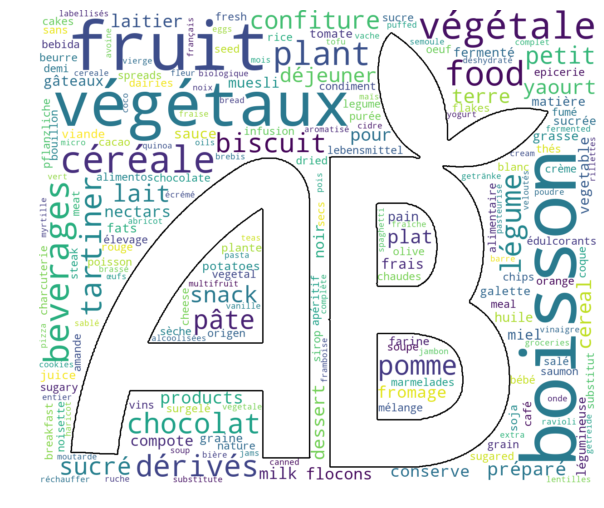

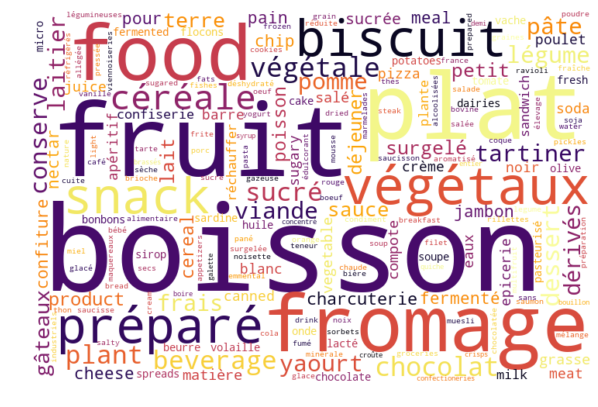

In [33]:
stopwords = {"base", "based", "origine", "produits", "aliment", "aliments"}
maskAB = generate_mask("data/images/logo-ab.jpg")
generateWordCloud(organicDf, stopwords, figsize = (10, 10), colormap = "viridis", mask=maskAB,contour_width=3, contour_color='black')
generateWordCloud(nonOrganicDf, stopwords, figsize = (10, 10), colormap = "inferno")

By looking at the wordclouds, it appears that organic and non organic products cover essetially the same markets. They are both essentially covering *drinks*, *fruits* and *vegetables*. However, they differ on many items. For instance, organic food is more interested in *cereals* and raw food, when non organic one covers more transformed food and already cooked meals.

#### Cereal example

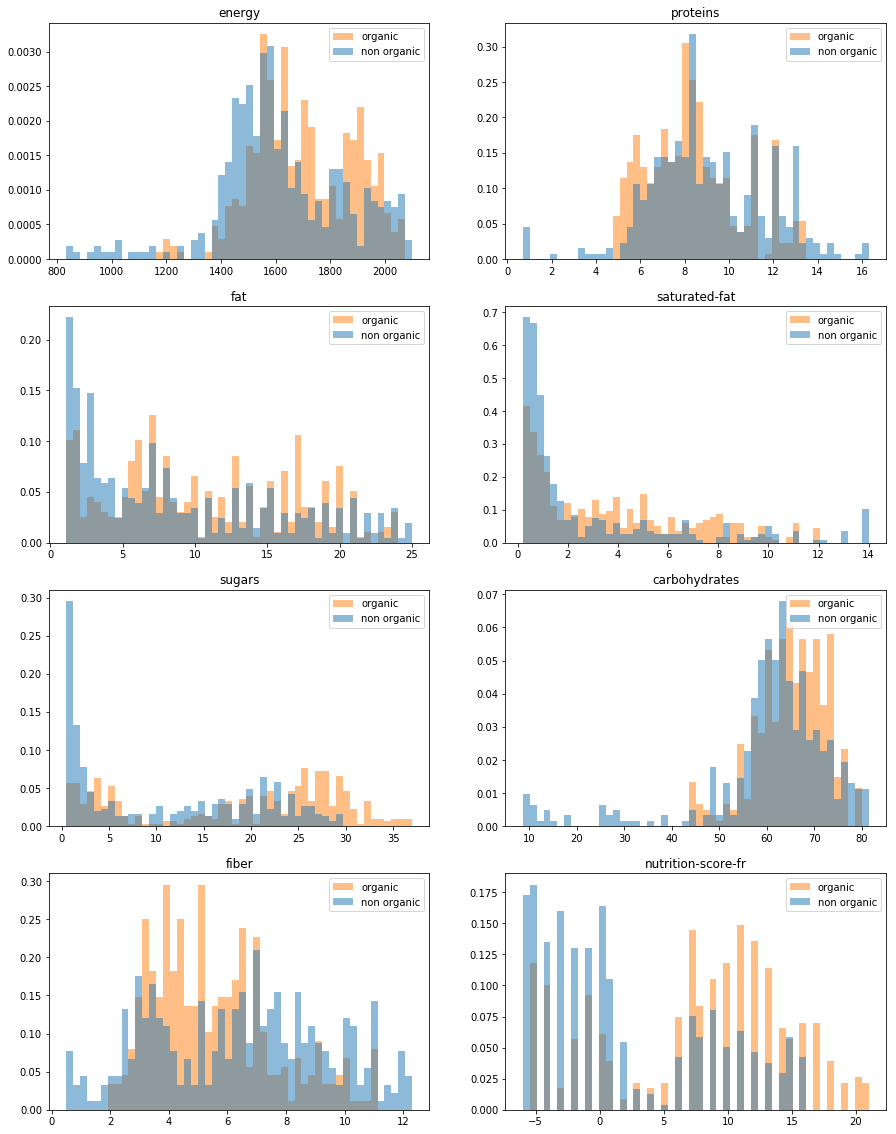

In [36]:
cats = ["céréales"]
catOrganic = gatherCategory(organicDf, cats)
catNOrganic = gatherCategory(nonOrganicDf, cats)
nutriments = ["energy","proteins","fat", "saturated-fat", "sugars","carbohydrates","fiber","nutrition-score-fr"]
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for i, nutriment in enumerate(nutriments):
    orgNut = gatherNutriments(catOrganic, nutriment)
    nOrgNut = gatherNutriments(catNOrganic, nutriment)
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        ax = axes[i // 2, i % 2]
        ax.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        ax.xlabel()
        ax.legend(["organic", "non organic"])
        ax.set_title(nutriment)
plt.show()

If we look more specifically at one category, for example *cereals*, we see that most of essential nutriments taken individually do not have a really different distribution between organic and not organic products. A striking fact is that the nutri-score for organic cereals is globally worse than the one for non-organic products.

#### Drink example

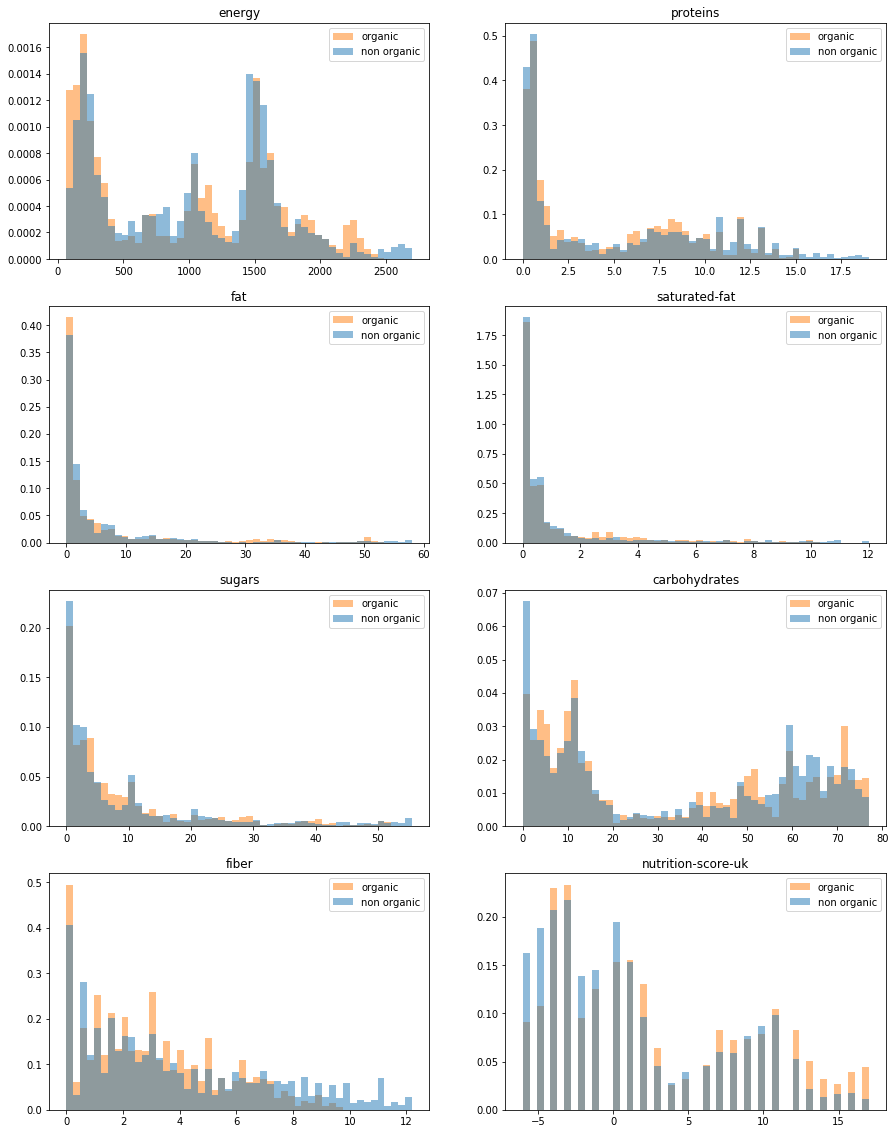

In [37]:
cats = ["boisson"]
catOrganic = gatherCategory(organicDf, cats)
catNOrganic = gatherCategory(nonOrganicDf, cats)

nutriments = ["energy","proteins","fat", "saturated-fat", "sugars","carbohydrates","fiber","nutrition-score-uk"]
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
for i, nutriment in enumerate(nutriments):
    orgNut = gatherNutriments(catOrganic, nutriment)
    nOrgNut = gatherNutriments(catNOrganic, nutriment)
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        ax = axes[i // 2, i % 2]
        ax.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        ax.legend(["organic", "non organic"])
        ax.set_title(nutriment)
plt.show()

If we look more specifically at another category, for example *drinks*, it seems that even the nutrition score does not differ between the two products.

## Study of INCA 2

### Data cleaning

In [38]:
# Data
plat = platform.system()
if plat =="Windows":
    encoding = "ansi" # Windows
elif plat =="Darwin":
    encoding = "latin" # Mac
else:
    raise ValueError("unknown os: {}".format(plat))

DATA_PATH = "data/{}.csv"

dfConso = pd.read_csv(DATA_PATH.format("Table_conso"), sep=";", encoding=encoding)
dfIndiv = pd.read_csv(DATA_PATH.format("Table_indiv"), sep=";", encoding=encoding)
dfCapiCA = pd.read_csv(DATA_PATH.format("Table_capi_ca"), sep=";", encoding=encoding)
dfCarnetCA = pd.read_csv(DATA_PATH.format("Table_carnet_ca_1"), sep=";", encoding=encoding)
dfIndivCA = pd.read_csv(DATA_PATH.format("Table_indiv_ca"), sep=";", encoding=encoding)
dfIndnut = pd.read_csv(DATA_PATH.format("Table_indnut"), sep=";", encoding=encoding)
dfMenage = pd.read_csv(DATA_PATH.format("Table_menage_1"), sep=";", encoding=encoding)
dfRepas = pd.read_csv(DATA_PATH.format("Table_repas"), sep=";", encoding=encoding)
dfNomenclature = pd.read_csv(DATA_PATH.format("Nomenclature_3"), sep=";", encoding=encoding)
dfCorrespondance = pd.read_csv(DATA_PATH.format("correspondance_reponses"), sep=";", encoding=encoding)
dfDataNames = pd.read_csv(DATA_PATH.format("Data_names_all"), sep=";", encoding=encoding)

dfDataCorrespondance = dfDataNames.merge(dfCorrespondance,left_on="Libellé du codage", right_on="Libellé du codage", how="inner")

### Data formating

In [39]:
def findCorrespondance(val, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    """
    Returns the description of the column signification.
    """
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    """
    Returns the description of the columns signification.
    """
    return [findDescription(column) for column in columns]

### Data analysis and visualization

#### BMI study

BMI (Body Mass Index) is an indicator frequently used to put in relation the weight and the height of an individual. BMI gives a value that allow to classify people in categories:

- (Very) Severely underweight: less than 16
- Underweight: 16-18.5
- Normal (healthy weight): 18.5-25
- Overweight: 25-30
- Obese Class I (Moderately obese): 30-35
- Obese Class II (Severely obese): 35-40
- Obese Class III-VI (Very severely obese-Hyper Obese): more than 40
_(source Wikipedia)_

The categories given above correspond to adults, we are going to exclude children from our study because their expected BMI changes with age.

Even if this indicator is not perfect (for instance profession athletes use to have a high BMI, synonymous of overweight, whereas they are in very good physical health), it is an easy tool that can allow us to identify some trends in the population.

The BMI is not directly accessible in our dataset but it can easily be computed thanks to the following formula:

$\text{BMI} = \frac{weight}{height^2} \text{kg/cm}^2$

We can study the BMI according to a huge range of categories. In order not to fill the notebook with plenty of figures that are not necessarily easily interpretable we've only let a sample of the figures we found the most significant.

In [40]:
def BMI_boxplots(dataframe, category, labels, tage=[4,5,6], x_label=None, category_name=None):
    '''
    Plot Body mass index (BMI) of males and females group by the given category.
    '''
    # select useful columns
    df = dataframe[list(set(["sexe_ps","poidsm","taille","tage",category]))]
    # select people in the given age category
    df = df.loc[df["tage"].isin(tage)]
    # compute bmi
    df["bmi"]=df["poidsm"]/((df["taille"]/100)**2)
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # 2 subplots : male and female
    for k in range(1,3):
        df_gender = df.loc[df["sexe_ps"]==k][["bmi",category]]
        count = df_gender[["bmi",category]].groupby(category).count().reset_index()
        df_gender[["bmi", category]].boxplot(by=category, ax=ax[k-1], rot=30)
        ax[k-1].set_ylabel("Body Mass Index (BMI)")
        if(x_label!=None):
            ax[k-1].set_xlabel(x_label)
        else:
            ax[k-1].set_xlabel(category.capitalize())
        labels_n = [labels[i]+"\n n = "+str(count["bmi"][i]) for i in range(len(labels))]
        ax[k-1].xaxis.set_ticklabels(labels_n)
    ax[0].set_title("Males", fontsize=12)
    ax[1].set_title("Females", fontsize=12)
    #background colors
    xrange = [(-1, 10)]
    yrange = [(0, 16.5),(16.5, 2),(18.5, 6.5),(25, 5),(30, 5),(35, 5),(40, 20)]
    colors = ['#21618c','#85c1e9','#58d68d','#FFC300','#FF5733','#C70039','#900C3F']
    for i in range(len(yrange)):
        c0 = collections.BrokenBarHCollection(xrange, yrange[i], facecolor=colors[i], alpha=0.5)
        c1 = collections.BrokenBarHCollection(xrange, yrange[i], facecolor=colors[i], alpha=0.5)
        ax[0].add_collection(c0)
        ax[1].add_collection(c1)
    name = category_name
    if(name==None):
        name = category.lower()
    fig.suptitle('Body mass index evolution with {}'.format(name), fontsize=16)
    plt.show()
    
def t_test(dataframe, gender, category, value_1, value_2):
    '''
    Compute a t-test to see if two series of values have significantly different means.
    '''
    df = dataframe.loc[(dataframe["sexe_ps"]==gender)]
    df["bmi"] = df["poidsm"]/((df["taille"]/100)**2)
    df_0 = df.loc[(df[category]==value_1)][["bmi"]].dropna()
    df_1 = df.loc[(df[category]==value_2)][["bmi"]].dropna()
    return ttest_ind(df_0, df_1, axis=0, equal_var=False)

#### BMI evolution with age

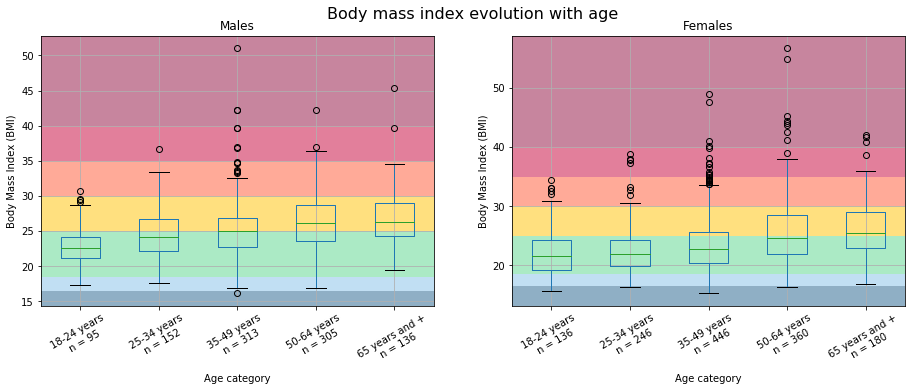

In [41]:
age = ['18-24 years', '25-34 years', '35-49 years', '50-64 years', '65 years and +']
BMI_boxplots(dfIndiv,"tage", age, tage=[4,5,6,7,8], x_label="Age category", category_name="age")

Interestingly we observe the same pattern for males and females (we will see later that it is not always the case). Older people tends to be overweight while younger people have a normal weight. Let's see if this trend is statistically significant.

In [42]:
test = """p_values for:\n
- males   (18-24 years) against males   (25-34 years):    {:.3e}
- males   (25-34 years) against males   (35-49 years):    {:.3e}
- males   (35-49 years) against males   (50-64 years):    {:.3e}
- males   (50-64 years) against males   (65 years and +): {:.3e}
- females (18-24 years) against females (25-34 years):    {:.3e}
- females (25-34 years) against females (35-49 years):    {:.3e}
- females (35-49 years) against females (50-64 years):    {:.3e}
- females (50-64 years) against females (65 years and +): {:.3e}
""".format(float(t_test(dfIndiv, 1, "tage", 4, 5).pvalue),
           float(t_test(dfIndiv, 1, "tage", 5, 6).pvalue),
           float(t_test(dfIndiv, 1, "tage", 6, 7).pvalue),
           float(t_test(dfIndiv, 1, "tage", 7, 8).pvalue),
           float(t_test(dfIndiv, 2, "tage", 4, 5).pvalue),
           float(t_test(dfIndiv, 2, "tage", 5, 6).pvalue),
           float(t_test(dfIndiv, 2, "tage", 6, 7).pvalue),
           float(t_test(dfIndiv, 2, "tage", 7, 8).pvalue),
          )
print(test)

p_values for:

- males   (18-24 years) against males   (25-34 years):    5.967e-05
- males   (25-34 years) against males   (35-49 years):    5.215e-02
- males   (35-49 years) against males   (50-64 years):    7.945e-04
- males   (50-64 years) against males   (65 years and +): 2.900e-01
- females (18-24 years) against females (25-34 years):    6.159e-01
- females (25-34 years) against females (35-49 years):    1.497e-04
- females (35-49 years) against females (50-64 years):    3.916e-08
- females (50-64 years) against females (65 years and +): 4.785e-01



A quick look at the p-values shows that the difference between two adjacent age categories is often significant. We did not displayed the p values for more distant categories (e.g. males (18-24 years) against males (50-64 years)) but they are of course lower.

#### BMI evolution with degree

The dataset gathers a lot of different kind of degrees. We gather them in 3 categories:

- No degree: individual who left school with no degree
- Vocational degree: higher degree is before the baccalauréat or correspond to a vocational/technical baccalauréat
- General degree: higher degree is a general baccalauréat or a university title (bachelor, master,...)

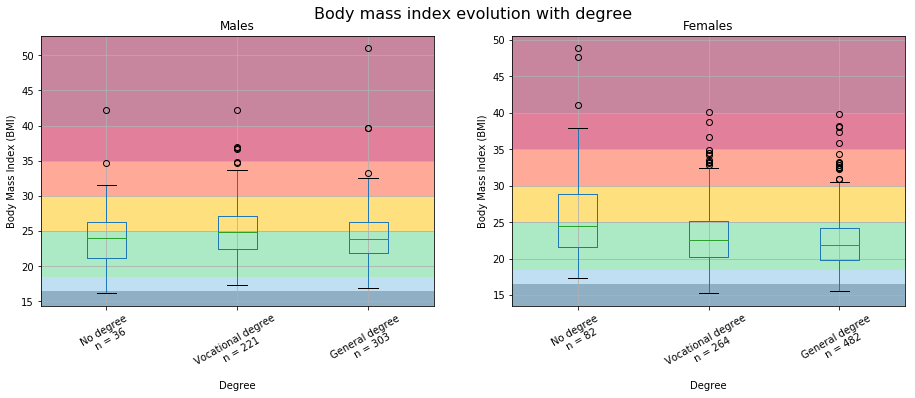

In [43]:
df = dfIndiv[["sexe_ps","poidsm","taille","dip","tage"]]
df["degree"] = (df["dip"]>5)*1+(df["dip"]>8)*1
type_of_degree = ['No degree', 'Vocational degree', 'General degree']
BMI_boxplots(df,"degree",tage=[4,5,6],labels=type_of_degree)

We identify a trend for females: the more advanced degree you have the less likely you are to be overweight. We cannot see this pattern with men but this can be linked to the fact that the first category (male with no degree) has not enough people in it so the results for this category are likely to be very noisy. Indeed if we compare male with vocational degree and male with general degree we see the same kind of pattern than with females. Let's see if it is significant:

In [44]:
test = """p_values for:\n
- males without degree against males with a vocational degree:            {:.3e}
- males without degree against males with a general degree:               {:.3e}
- males with a vocational degree against males with a general degree:     {:.3e}
- females without degree against females with a vocational degree:        {:.3e}
- females without degree against females with a general degree:           {:.3e}
- females with a vocational degree against females with a general degree: {:.3e}
""".format(float(t_test(df, 1, "degree", 0, 1).pvalue),
           float(t_test(df, 1, "degree", 0, 2).pvalue),
           float(t_test(df, 1, "degree", 1, 2).pvalue),
           float(t_test(df, 2, "degree", 0, 1).pvalue),
           float(t_test(df, 2, "degree", 0, 2).pvalue),
           float(t_test(df, 2, "degree", 1, 2).pvalue)
          )
print(test)

p_values for:

- males without degree against males with a vocational degree:            8.664e-02
- males without degree against males with a general degree:               2.732e-01
- males with a vocational degree against males with a general degree:     1.045e-06
- females without degree against females with a vocational degree:        1.074e-02
- females without degree against females with a general degree:           2.113e-09
- females with a vocational degree against females with a general degree: 4.634e-10



Appart from the category "male with no degree" that has to few individual in it, the comparisons are all significant.

#### Food habits

We tried to see if interest in food could have an impact on BMI. However the very small number of persons in some categories does not allow us to draw any clear conclusion.

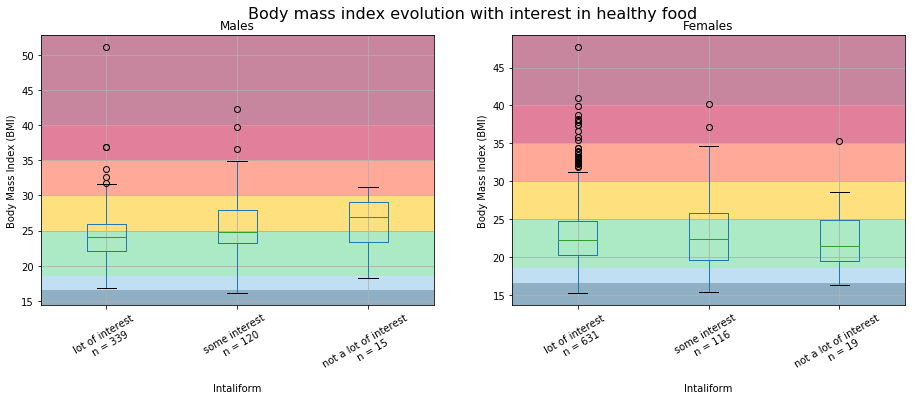

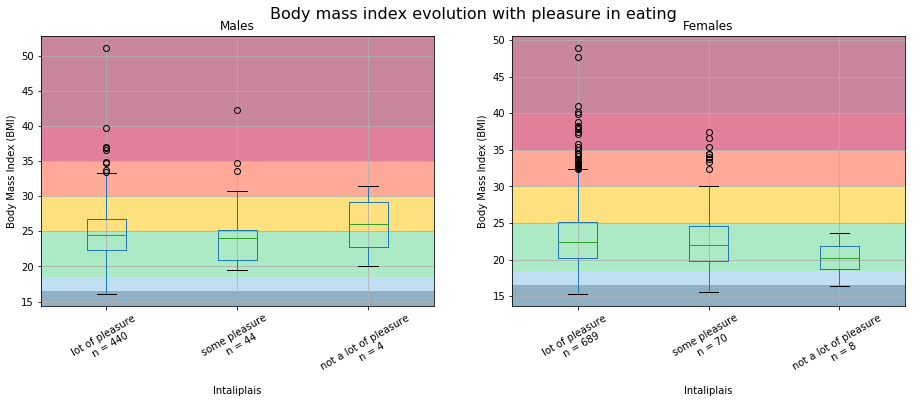

In [45]:
df = dfIndiv[["sexe_ps","poidsm","taille","intaliform","tage"]].loc[dfIndiv["intaliform"].isin([1,2,3,4])]
interest_labels = ["lot of interest", "some interest", "not a lot of interest"]
BMI_boxplots(df,"intaliform",labels=interest_labels, tage=[4,5,6], category_name="interest in healthy food")

df = dfIndiv[["sexe_ps","poidsm","taille","intaliplais","tage"]].loc[dfIndiv["intaliplais"].isin([1,2,3,4])]
pleasure_labels = ["lot of pleasure", "some pleasure", "not a lot of pleasure"]
BMI_boxplots(df,"intaliplais",labels=pleasure_labels, tage=[4,5,6], category_name="pleasure in eating")

#### BMI evolution with living place

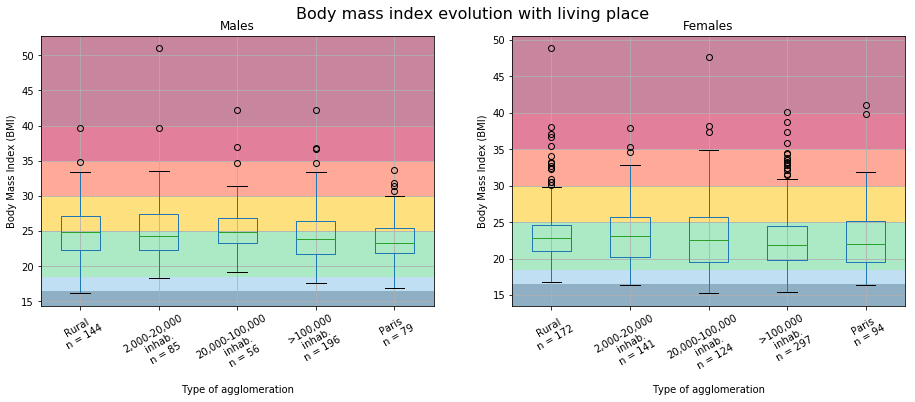

In [46]:
type_of_town = ['Rural', '2,000-20,000\n inhab.', '20,000-100,000\n inhab.', '>100,000\n inhab.', 'Paris']
BMI_boxplots(dfIndiv,"agglo5",labels=type_of_town, tage=[4,5,6],x_label="Type of agglomeration", category_name="living place")

We do not see clear trends. There seems to be a bit less overweight people in very big agglomerations but this trend disappears if we plot the results of just one age category. This is not very surprising as we expect to have more elderly persons in rural areas and have we have seen before, the older the higher the BMI.

Let's look at the difference between regions. In order not to show aberrant values we only plot the average BMI in regions with more than 30 individuals of the gender studied.

In [47]:
def filterRegions(threshold, gender, tage):
    '''
    Returns the regions with more than 40 persons of the given gender.
    '''
    df = dfIndiv[["sexe_ps","poidsm","taille","tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df = df.loc[df["sexe_ps"]==gender][["sexe_ps","region"]].groupby("region").count()
    df_under_th = df.loc[df["sexe_ps"]<threshold]
    NoData = [i for i in df_under_th.index]
    regions_geo_path = "data/regions-avant-redecoupage-2015.geojson"
    geo_json_data = json.load(open(regions_geo_path))
    i = 0
    while i < len(geo_json_data['features']):
        g = geo_json_data['features'][i]['properties']
        if int(g['code']) in NoData:
            del geo_json_data['features'][i]
        else:
            i += 1
    return geo_json_data


def BMI_map(gender, threshold=30, tage=[4,5,6]):
    '''
    Returns the map of the average BMI for individual of the given gender and age.
    Only displays the regions where there are at least 30 individuals in order to have meaningful values.
    '''
    df = dfIndiv[["sexe_ps","poidsm","taille","tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df["imc"]=df["poidsm"]/((df["taille"]/100)**2)
    df_gender = df.loc[df["sexe_ps"]==gender][["imc","region"]].groupby("region").mean()
    df_gender["region"] = df_gender.index
    df_gender["region"] = df_gender["region"].astype(str)
    geo_json_data = filterRegions(threshold=threshold, gender=gender, tage=tage)
    m_france = folium.Map([46.6, 4], zoom_start=5)
    m_france.choropleth(
     geo_data=geo_json_data,
     data=df_gender,
     columns=['region', 'imc'],
     key_on='feature.properties.code',
     fill_color='OrRd',
     fill_opacity=0.7,
     line_opacity=0.7,
     legend_name="Body Mass Index",
    highlight=True
    )
    return m_france

In [48]:
m_france_male = BMI_map(1)
m_france_male

In [49]:
m_france_female = BMI_map(2)
m_france_female

The main problem with this representation is that there are too many regions where we lack data. This is partly due to the fact that we have displayed two maps (one for men and one for women) so we can only use half of the indiviuals of the dataset to display one map or the other.

### Tobacco consumption with living place

We can make the choice to gather men and women and to display only one map, for instance a map displaying tobacco consumption.

In [50]:
def filterRegions(dataframe, threshold, category, tage):
    '''
    Returns the regions with more than 40 persons.
    '''
    df = dataframe[[category,"tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df = df[[category,"region"]].groupby("region").count()
    df_under_th = df.loc[df[category]<threshold]
    NoData = [i for i in df_under_th.index]
    regions_geo_path = "data/regions-avant-redecoupage-2015.geojson"
    geo_json_data = json.load(open(regions_geo_path))
    i = 0
    while i < len(geo_json_data['features']):
        g = geo_json_data['features'][i]['properties']
        if int(g['code']) in NoData:
            del geo_json_data['features'][i]
        else:
            i += 1
    return geo_json_data


def Category_map(dataframe, category, legend, threshold=30, tage=[4,5,6,7,8]):
    '''
    Returns the map of the average value of the studied category for individual of the given age.
    Only displays the regions where there are at least 30 individuals in order to have meaningful values.
    '''
    df = dataframe[[category,"tage","region"]]
    df = df.loc[(df["tage"].isin(tage))]
    df = df.groupby("region").mean()
    df["region"] = df.index
    df["region"] = df["region"].astype(str)
    geo_json_data = filterRegions(dataframe, threshold, category, tage)
    m_france = folium.Map([46.6, 4], zoom_start=5)
    m_france.choropleth(
     geo_data=geo_json_data,
     data=df,
     columns=['region', category],
     key_on='feature.properties.code',
     fill_color='PuRd',
     fill_opacity=0.7,
     line_opacity=0.7,
     legend_name=legend,
     highlight=True
    )
    return m_france

In [51]:
df = dfIndiv.loc[(dfIndiv["fume"].isin([1,2,3,4]))]
df["tobacco"] = (df["fume"]<3)*1
m_france = Category_map(df,"tobacco","Proportion of smokers")
m_france

#### Displaying functions

In [52]:
def plotBar(table, x, y, index=None):
    """
    Plots a stacked normalized bar plot from table. Axis x is x, axis y is y, count is column index.
    """
    if index == None: index = y
    consos = table[[x, y, index]].groupby([x, y]).count().unstack(level=1)[index]
    consos = consos.swapaxes(0,1)
    consos = consos / consos.sum(axis=0)
    consos = consos.swapaxes(0,1)
    consos.index = mapCorrespondances(consos.index, x)
    consos.columns = mapCorrespondances(consos.columns, y)
    consos.plot.bar(stacked=True)
    plt.show()

def plotScatter(table, col1, col2):
    """
    Scatters columns col1 and columns col2 of table
    """
    data = table[[col1, col2]].values
    plt.scatter(data[:,0], data[:,1])
    plt.show()
    
def getBinsFunc(x, nbins):
    """
    Create a function mapping x values into a categorical 
    """
    xmin = np.min(x)
    xmax = np.max(x) * 1.01
    return lambda v: np.int16(nbins * (v - xmin) / (xmax - xmin)) * (xmax - xmin) + xmin
    
def plotScatterCateX(table, x, y, index, nbins):
    """
    Plots a stacked normalized bar plot from table. Axis x is x, axis y is y, count is column index.
    Column index is filtered into nbins bins.
    """
    consos = table[[x, y, index]]
    f = getBinsFunc(consos[y], nbins)
    consos[y] = f(consos[y])
    plotBar(consos, x, y, index)

def plotMeanValues(table, features, className, mincount=50):
    """
    Plot a normalized stacked bar chart of mean values of each features in features for each class according to 
    class name. Consider only classes with at least mincount elements.
    """
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, figsize=figsize)
    plt.show()